In [21]:
import numpy       as np
import matplotlib.pyplot as plt
import numpy       as np
import matplotlib as mpl
import pandas as pd
import glob 
import os
import warnings
warnings.filterwarnings('ignore')

In [22]:
def Weigfun( Tlag): 
    # WEIGFUN Summary of this function goes here
    #   Detailed explanation goes here
    nmax=int(np.ceil(Tlag))
    
    if nmax==1: 
        Weigths=float(1)
    else:
        Weigths=np.zeros(nmax)

        th=Tlag/2
        nh=int(np.floor(th))
        for i in range(0,nh): 
            Weigths[i]=(float(i+1)-0.5)/th        
        i=nh

        Weigths[i]=(1+(float(i+1)-1)/th)*(th-int(np.floor(th)))/2+(1+(Tlag-float(i+1))/th)*(int(np.floor(th))+1-th)/2
        for i in range(nh+1, int(np.floor(Tlag))):
            Weigths[i]=(Tlag-float(i+1)+.5)/th

        if Tlag>int(np.floor(Tlag)):
            Weigths[int(np.floor(Tlag))]=(Tlag-int(np.floor(Tlag)))**2/(2*th)

        Weigths=Weigths/sum(Weigths)

    return(Weigths)
    # plot(Weigths)


In [112]:
def HBVMod(Par, forcing, Sin, n_day, snow=True, mode='training'):
        #HBVpareto Calculates values of 3 objective functions for HBV model

    Imax = Par[0]
    Ce = Par[1]
    Sumax = Par[2]
    beta = Par[3]
    Pmax = Par[4]
    Tlag = Par[5]
    Kf = Par[6]
    Ks = Par[7]
    FM = 3  # mm/deg/d
    Tt = -0.5  # degc  
    

    Prec = forcing['P'].values
    Qo = forcing['Q'].values
    Etp = forcing['Pe'].values
    temp = forcing['T'].values
    Psnow = np.zeros(len(Prec))
    Pldt = np.zeros(len(Prec))

    tmax = len(Prec)
    
    # allocate Si, Su, Sf, Ss, Eidt, Eadt, Qtotdt
    
    Si = np.zeros(tmax)
    Su = np.zeros(tmax)
    Sf = np.zeros(tmax)
    Ss = np.zeros(tmax)
    Ssnow = np.zeros(tmax)
    Eidt = np.zeros(tmax)
    Eadt =  np.zeros(tmax)
    Qtotdt = np.zeros(tmax)
    Qs = np.zeros(tmax)
    Qf = np.zeros(tmax)
    
    # initialize Si, Su, Sf, Ss, Ssnow
    Si[0] = Sin[0]
    Su[0] = Sin[1]
    Sf[0] = Sin[2]
    Ss[0] = Sin[3]
    Ssnow[0] = Sin[4]

    dt = 1
    Er = 331 #m
    

    
    # Model 1 SOF1
    for i in range(0, tmax):
        Epdt = Etp[i] * dt
        TR = temp[i] * dt
        #Ti = TR - 0.6 * (Ei-Er) / 100
        Ti = TR
        if snow: 
            if Ti < Tt and i != 0:
                Pdt               = 0                                                     # no rainfall
                Ps                = Prec[i] * dt                                          # precipitation is snow 
                M                 = 0                                                     # Too cold for melt
                Ssnow[i]          = Ssnow[i-1] + Ps                                       # add snow to the prev day
                Pldt[i]              = 0                                                     # no outflow as too cold
            # then must be above
            else:
                Pdt               = Prec[i] * dt                                          # all precip is rainfall
                Ps                = 0                                                     # no snow 
                M                 = min(Ssnow[i-1] / dt, FM * (Ti - Tt))                  # calculate melt
                Ssnow[i]          = Ssnow[i-1] - M * dt                                   # remove melted snow
                Pldt[i]           = M                                               # outflow = melt
            if i < tmax-1:
                Ssnow[i+1] = Ssnow[i]
            
        else:
            Pdt               = Prec[i] * dt 
            Pldt[i] = 0
            Ps = 0
            
        # Interception Reservoir
        if Pdt > 0:
            Si[i] = Si[i] + Pdt
            Pedt = np.maximum(0, (Si[i] - Imax) / dt) + Pldt[i] #Outflow of snow storage is added here
            Si[i] = Si[i] - Pedt
            Eidt[i] = 0
        else:
        # Evaporation only when there is no rainfall
            Pedt = np.maximum(0, (Si[i] - Imax) / dt) + Pldt[i] #is zero, because of no rainfall
            Eidt[i] = np.minimum(Epdt, Si[i] / dt)
            Si[i] = Si[i] - Pedt - Eidt[i]
        
        if i < tmax-1:
            Si[i+1] = Si[i]
        
        
        # Split Pe into Unsaturated Reservoir and Preferential reservoir
        if Pedt > 0:
            Cr = (Su[i] / Sumax) ** beta
            Qiudt = (1 - Cr) * Pedt # flux from Ir to Ur
            Su[i] = Su[i] + Qiudt
            Qufdt = Cr * Pedt #flux from Su to Sf
        else:
            Qufdt = 0
        
        # Transpiration
        Epdt = max(0, Epdt - Eidt[i])
        Eadt[i] = Epdt * (Su[i] / (Sumax * Ce))
        Eadt[i] = min(Su[i] / dt, Eadt[i])
        Su[i] = Su[i] - Eadt[i]
        
        # Percolation
        Qusdt = Pmax * (Su[i] / Sumax) * dt # Flux from Su to Ss
        Su[i] = Su[i] - Qusdt
        
        if i < tmax - 1:
            Su[i+1] = Su[i]
        
        # Fast Reservoir
        Sf[i] = Sf[i] + Qufdt
        Qfdt = dt * Kf * Sf[i]
        Sf[i] = Sf[i] - Qfdt

        if i < tmax-1:
            Sf[i+1] = Sf[i]
        
        # Slow Reservoir
        Ss[i] = Ss[i] + Qusdt
        Qsdt = dt * Ks * Ss[i]
        Ss[i] = Ss[i] - Qsdt
        if i < tmax-1:
            Ss[i+1] = Ss[i]
        
        Qtotdt[i] = Qsdt + Qfdt
        Qs[i] = Qsdt 
        Qf[i] = Qfdt 
        
        Psnow[i] = Ps


    # Check Water Balance
    Sout = np.array([Si[-1], Su[-1], Sf[-1], Ss[-1], Ssnow[-1]]) # initialize Si, Su, Sf, Ss, Ssnow
    Sf = Si[-1] + Ss[-1] + Sf[-1] + Su[-1] + Ssnow[-1] #final storage
    Sin = sum(Sin) #initial storage
    WB = sum(Prec) - sum(Eidt) - sum(Eadt) - sum(Qtotdt) - Sf + Sin

    # Offset Q

    Weigths = Weigfun(Tlag)
    
    Qm = np.convolve(Qtotdt, Weigths)
    Qm = Qm[0:tmax]
    forcing['Qm'] = Qm
    forcing['PSnow'] = Psnow
    forcing['S_snow'] = Ssnow
    forcing['Pl_snow'] = Pldt
    
    #Use n_days for spinoff to compensate for initial storage
    if mode == 'training':
        Qo = Qo[n_day:]       
        Qm = Qm[n_day:]       
        
        
    # Calculate objective
    ind = np.where(Qo>=0)
    QoAv = np.mean(Qo[ind])
    ErrUp = np.sum((Qo - Qm) ** 2)
    ErrDo = np.sum((Qo - QoAv) ** 2)
    Obj = 1 - (ErrUp / ErrDo)

        
    return forcing, Obj, Sout


    # leg['Qobs','Qmod']

In [113]:
def align_zeros(axes):
    ylims_current = {}   #  Current ylims
    ylims_mod     = {}   #  Modified ylims
    deltas        = {}   #  ymax - ymin for ylims_current
    ratios        = {}   #  ratio of the zero point within deltas
    for ax in axes:
        ylims_current[ax] = list(ax.get_ylim())
                        # Need to convert a tuple to a list to manipulate elements.
        deltas[ax]        = ylims_current[ax][1] - ylims_current[ax][0]
        ratios[ax]        = -ylims_current[ax][0]/deltas[ax]
        
    for ax in axes:      # Loop through all axes to ensure each ax fits in others.
        ylims_mod[ax]     = [np.nan,np.nan]   # Construct a blank list
        ylims_mod[ax][1]  = max(deltas[ax] * (1-np.array(list(ratios.values()))))
                        # Choose the max value among (delta for ax)*(1-ratios),
                        # and apply it to ymax for ax
        ylims_mod[ax][0]  = min(-deltas[ax] * np.array(list(ratios.values())))
                        # Do the same for ymin
        ax.set_ylim(tuple(ylims_mod[ax]))

In [114]:
path = os.getcwd()
home_path = os.path.dirname(path)
data_folder = f'{home_path}\\Data'
files = glob.glob(f"{data_folder}\\*.parquet")
df_data = pd.read_parquet(files[0]).dropna()

In [115]:
#df_data = pd.read_parquet(files[0]).dropna()
files = glob.glob(f"{data_folder}\\EP\\combined*.parquet")
df_EP = pd.read_parquet(files[1]).dropna()

In [116]:
df_data_comb = pd.concat([df_data, df_EP], axis=1)
df_data_comb.dropna(inplace=True)
df_data_comb.head()

,T,Pev,P,Q,Pe
1980-01-01,-4.244118,0.212411,0.000000,1.432909,0.212411
1980-01-02,-3.066830,0.167835,0.000000,1.367777,0.167835
1980-01-03,-6.372549,0.235660,0.023756,1.335211,0.235660
1980-01-04,-10.202124,0.167202,0.000000,1.253795,0.167202
1980-01-05,-7.726471,0.192151,0.000000,1.179358,0.192151


In [218]:
          #      Imax Ce Sumax beta Pmax   Tlag   Kf  Ks 
ParMinn = np.array([0.1,   0.1,  40,    .1,   .001,   0.001,     .0001,  .001])
ParMaxn = np.array([5,    0.85,  100,   8,    10.0,     10,    0.1,   1])
Sin = np.array([0,  100,  0,  5, 0])

#split data in before and after 2000
end = '2000'
df_data_before = df_data_comb.loc[:end]
df_data_after = df_data_comb.loc[end:]


df_data_before_training = df_data_before.loc[:'1990']
df_data_before_test = df_data_before.loc['1990':]
df_data_after_training = df_data_after.loc[:'2010']
df_data_after_test = df_data_after.loc['2010':]

In [219]:
def calibration(df, n_max, Par_Maxn, Par_Minn, S_in, snow=True, mode='Training'):
    # GLUE
    nmax = n_max
    A = np.zeros((nmax,9))
    Sout_lst = np.zeros((nmax, len(S_in)))
    n_feasible = 0

    for n in range(1,nmax): 
        Rnum = np.random.random(8)  #generate a vector of random number

        Par = Rnum * (Par_Maxn - Par_Minn) + Par_Minn # calculate the random parameter set
        df, Obj, Sout = HBVMod(Par, df, Sin, 365+180, snow=snow, mode=mode) #call the model

        if Obj>0:
            A[n_feasible,0:8]         = Par
            A[n_feasible,8]           = Obj
            Sout_lst[n_feasible, :]   = Sout
            n_feasible                = n_feasible + 1


    np.savetxt(f'{data_folder}\\MC2_before.txt',A[0:n_feasible,:], delimiter =',')


    #find the optimum

    Opt_obj = A.argmax(axis=0)[8]
    
    #find the optimal parameter set
    OptPar   = A[Opt_obj, 0:8]
    Sout = Sout_lst[Opt_obj, :]
    NSE = A[Opt_obj, 8]
    
    return OptPar, Sout, NSE
    

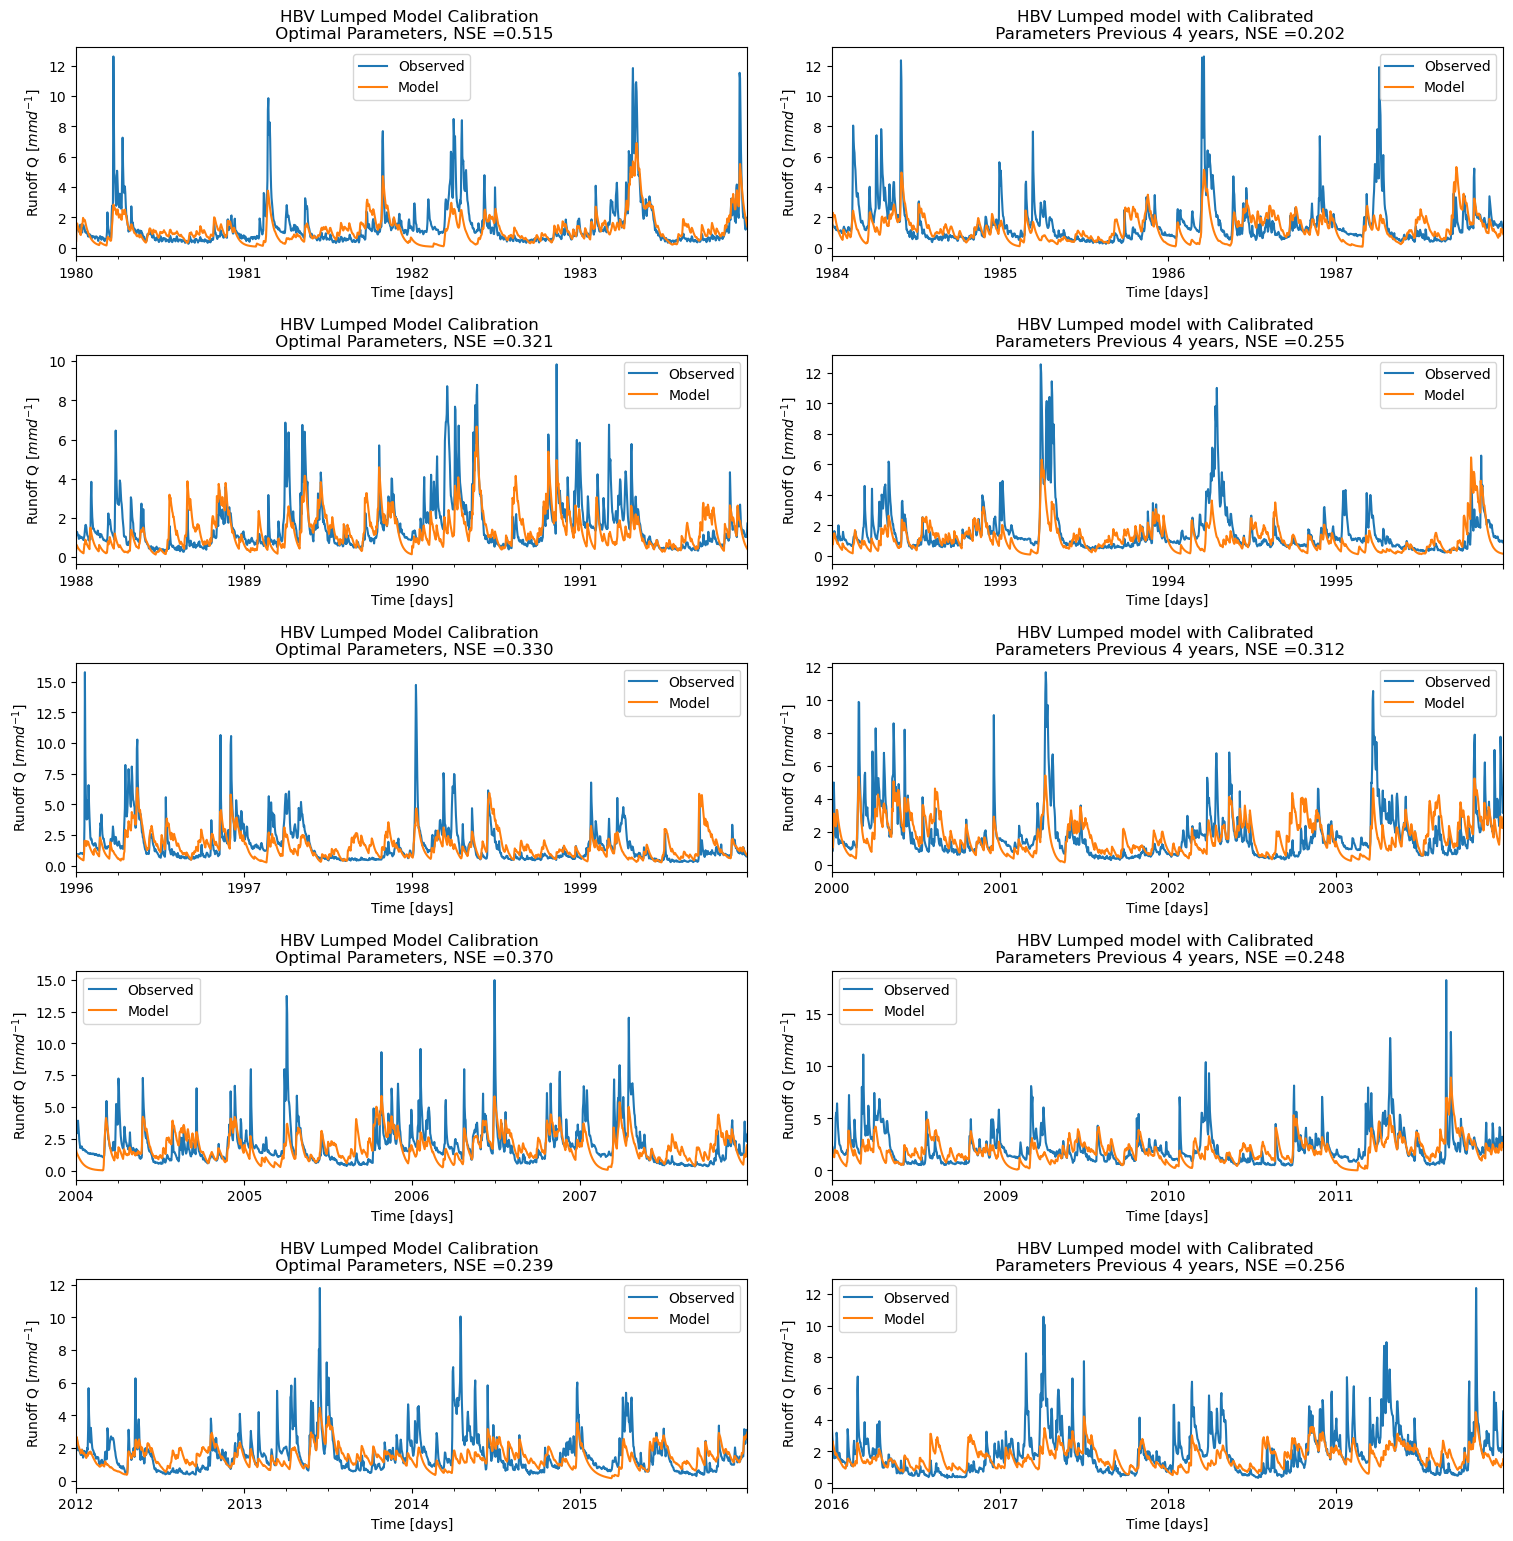

In [269]:
OptPar_lst = []
Sout_lst = []
NSE_lst = []
a=0
start = 1980

fig, ax = plt.subplots(5, 2, figsize=(15,15))
plt.tight_layout(h_pad=5, w_pad=3)

for i in range(10):
    end = start + 3
    
    if (i % 2) == 0:
        OptPar, Sout, NSE = calibration(df_data_comb.loc[str(start):str(end)], 20000, ParMaxn, ParMinn, Sin)
        OptPar_lst.append(OptPar)
        Sout_lst.append(Sout)
        NSE_lst.append(NSE)
        df, Obj, _ = HBVMod(OptPar_lst[a], df_data_comb.loc[str(start):str(end)], Sout_lst[a], 0, snow=True,  mode='Test')
        c = 0 
        ax[a, c].set_title(f'HBV Lumped Model Calibration \n Optimal Parameters, NSE ={Obj:.3f}')
    else:
        df, Obj, _ = HBVMod(OptPar_lst[a], df_data_comb.loc[str(start):str(end)], Sout_lst[a], 0, snow=True,  mode='Test')
        c = 1
        ax[a, c].set_title(f'HBV Lumped model with Calibrated \n Parameters Previous 4 years, NSE ={Obj:.3f}')
    
    df.Q.plot(label='Observed', ax=ax[a, c])
    df.Qm.plot(label='Model',  ax=ax[a, c])
    
    ax[a, c].set_xlabel('Time [days]')
    ax[a, c].set_ylabel('Runoff Q [$mmd^{-1}$]')
    
    ax[a, c].legend()    
    start += 4
    if (i % 2) != 0:
        a += 1
    



In [271]:
fig.savefig('Figures\\splitter_10d_runs2.png', dpi=1000)

0.5173833238372094
0.32926369899439234
0.36854841102622005
0.3888212819412942
0.2431298750367843


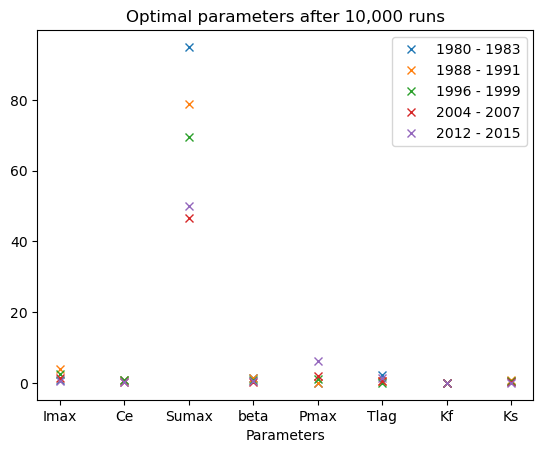

In [272]:
par = np.array(['Imax' , 'Ce' , 'Sumax' , 'beta', 'Pmax',    'Tlag',    'Kf',  'Ks' ])
y=0

fig, ax = plt.subplots()
for i in range(5):
    ax.plot(par, OptPar_lst[i], 'x', color=f'C{i}', label=f'{str(1980 + y)} - {str(1983 + y)}')
    print(NSE_lst[i])
    y += 8
ax.legend()
ax.set_xlabel('Parameters')

ax.set_title('Optimal parameters after 10,000 runs')

fig.savefig(f'Figures\\params_different_years_10d_1.png')

In [153]:
OptPar_100d, Sout_100d, NSE_100d = OptPar, Sout, NSE

In [ ]:
OptPar, Sout, NSE = calibration(df_data_comb.loc['1980':'1985'], 100000, ParMaxn, ParMinn, Sin)

3.075723433210935
0.817686673765801
73.00399038286788
0.692521729113112
0.013063356718182328
0.7471023581383092
0.09964283190706213
0.23457213371909788


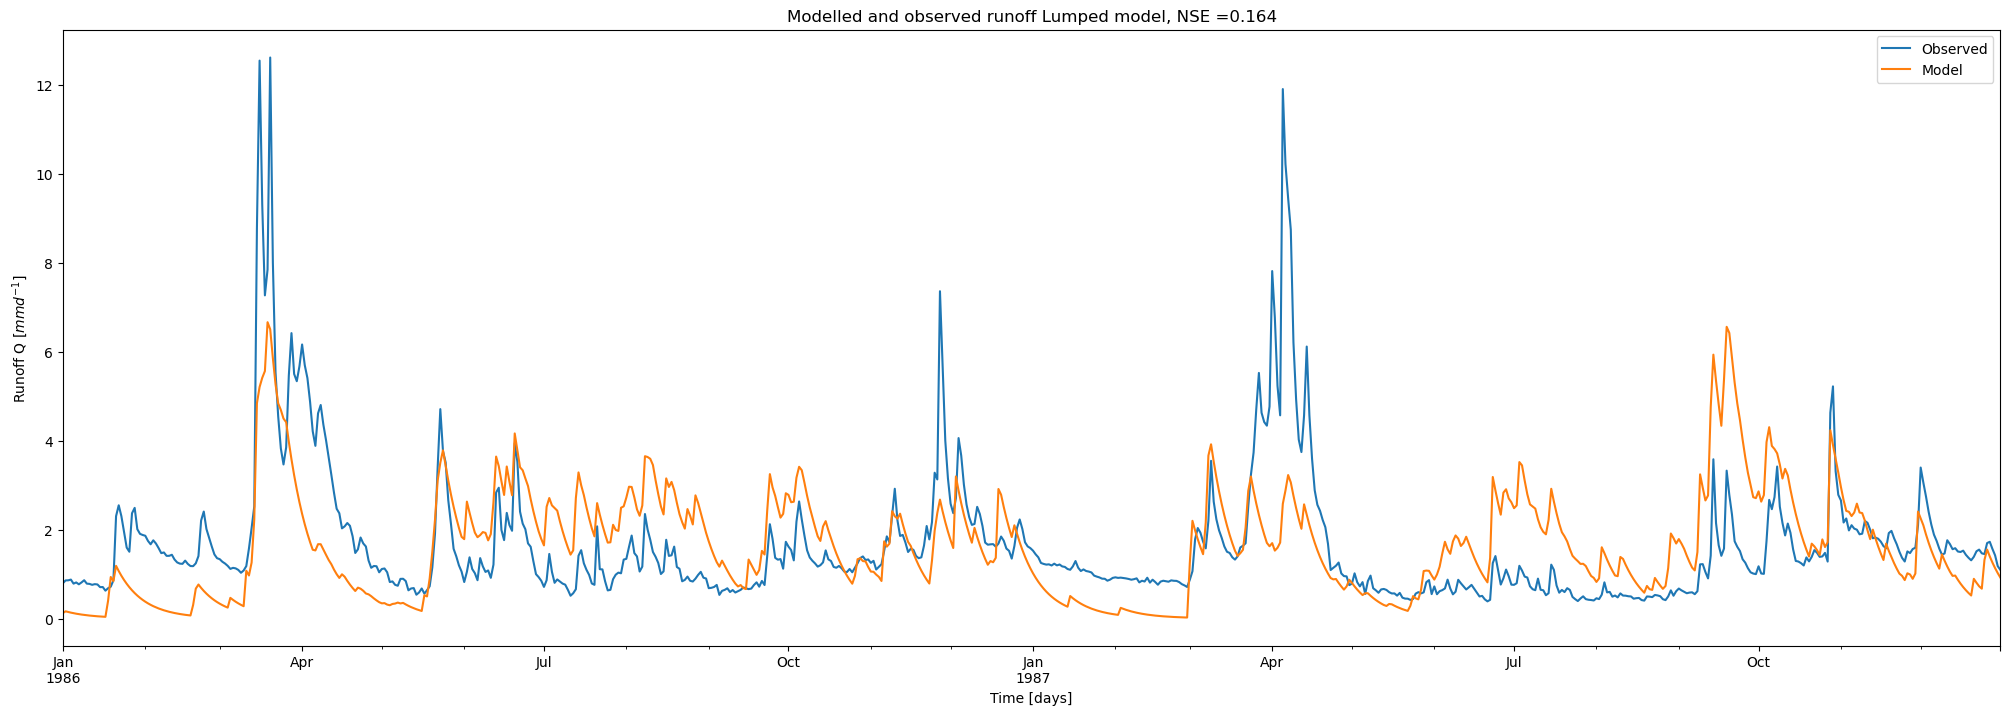

In [157]:
df_before_test, Obj_before_test, _ = HBVMod(OptPar_100d, df_data_comb.loc['1986':'1987'], Sout_100d, 0, snow=True,  mode='Test')
fig, ax = plt.subplots(figsize=(25,8))

df_before_test.Q.plot(label='Observed', ax=ax)
df_before_test.Qm.plot(label='Model',  ax=ax)

ax.set_xlabel('Time [days]')
ax.set_ylabel('Runoff Q [$mmd^{-1}$]')
ax.set_title(f'Modelled and observed runoff Lumped model, NSE ={Obj_before_test:.3f}')
ax.legend()

for i in range(8):
    print(OptPar_100d[i])


0.387199964739779
0.310901818558746
0.34324699458655306
0.3220825394271757
0.24383384828098975
0.261886161985602
0.32828075281485836
0.30561984030281397


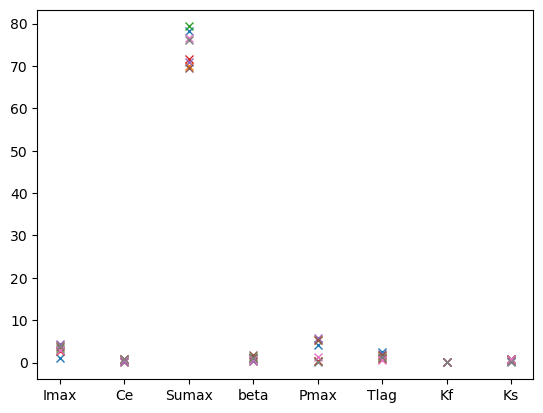

In [147]:
par = np.array(['Imax' , 'Ce' , 'Sumax' , 'beta', 'Pmax',    'Tlag',    'Kf',  'Ks' ])

for i in range(8):
    plt.plot(par, OptPar_lst[i], 'x', color=f'C{i}')
    print(NSE_lst[i])

In [79]:
# GLUE
nmax = 1000
A = np.zeros((nmax,9))
Sout_lst = np.zeros((nmax, len(Sin)))
n_feasible = 0

for n in range(1,nmax): 
    Rnum = np.random.random(8)  #generate a vector of random number
    
    Par = Rnum * (ParMaxn - ParMinn) + ParMinn # calculate the random parameter set
    df, Obj, Sout = HBVMod(Par, df_data_before_training, Sin, 365+180, snow=True) #call the model

    if Obj>0:
        A[n_feasible,0:8]         = Par
        A[n_feasible,8]           = Obj
        Sout_lst[n_feasible, :]   = Sout
        n_feasible                = n_feasible + 1


np.savetxt(f'{data_folder}\\MC2_before.txt',A[0:n_feasible,:], delimiter =',')


#find the optimum

Opt_obj_before_training = A.argmax(axis=0)[8]

#find the optimal parameter set
OptPar_before_training   = A[Opt_obj_before_training, 0:8]
Sout_Opt_before_training = Sout_lst[Opt_obj_before_training, :]

training 0.361, test 0.329
Imax: 1.126, Ce: 0.244, Sumax: 73.681, beta: 0.808,Pmax: 7.853,   Tlag: 0.070,   Kf: 0.038,  Ks: 0.283


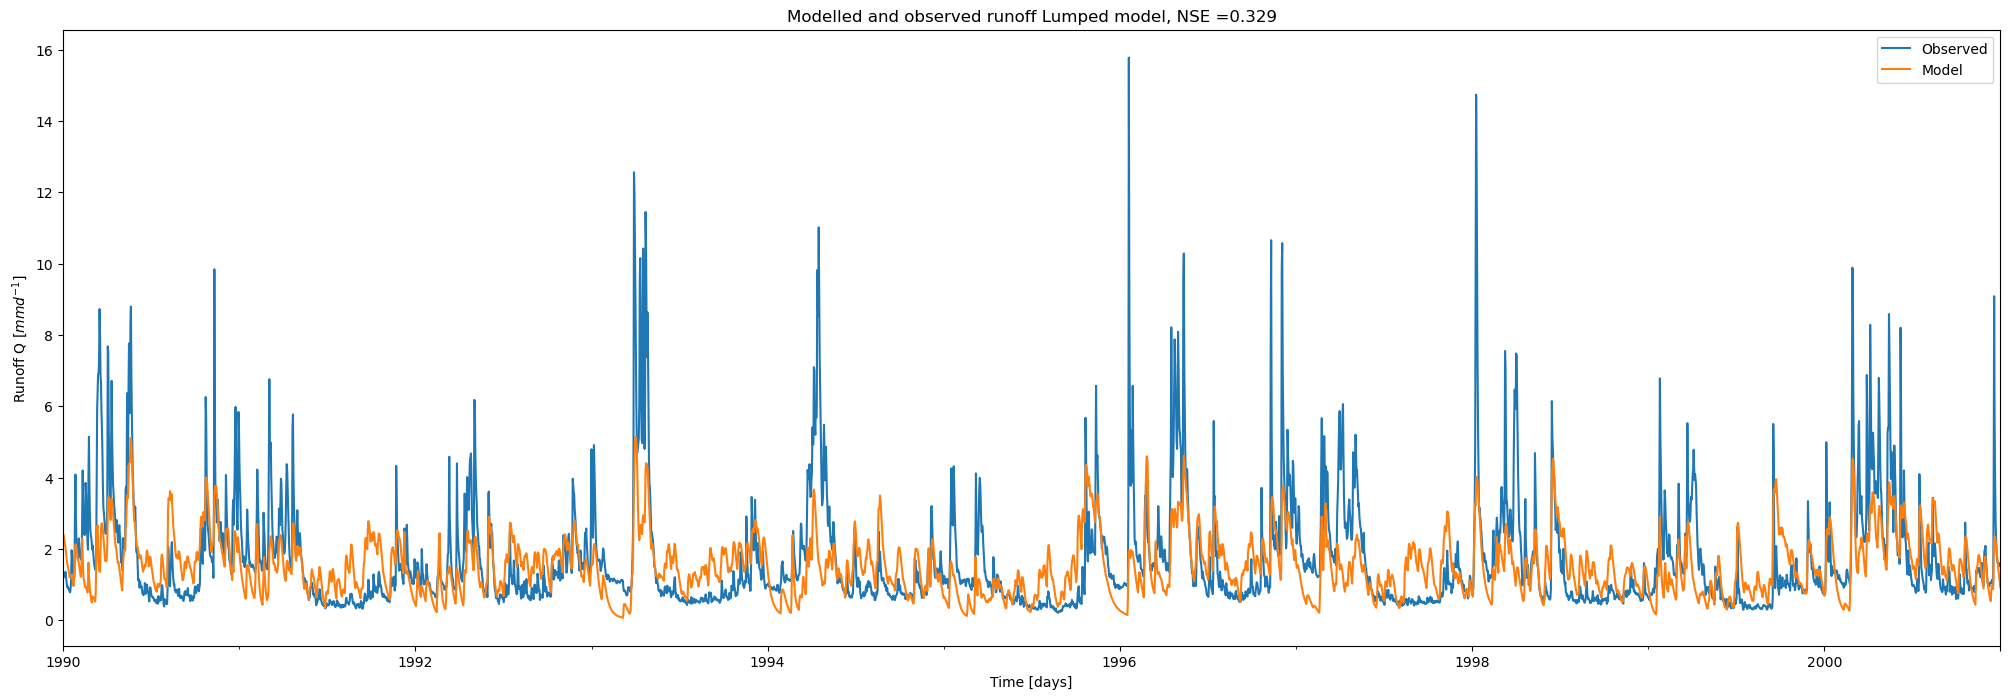

In [83]:
df_before_test, Obj_before_test, _ = HBVMod(OptPar_before_training, df_data_before_test, Sout_Opt_before_training, 0, snow=True,  mode='Test')

fig, ax = plt.subplots(figsize=(25,8))
#ax2=ax.twinx()
df_before_test.Q.plot(label='Observed', ax=ax)
df_before_test.Qm.plot(label='Model',  ax=ax)

ax.set_xlabel('Time [days]')
ax.set_ylabel('Runoff Q [$mmd^{-1}$]')
ax.set_title(f'Modelled and observed runoff Lumped model, NSE ={Obj_before_test:.3f}')
ax.legend()

print(f'training {A[Opt_obj_before_training, 8]:.3f}, test {Obj_before_test:.3f}')
#align_zeros([ax,ax2])

print(f'Imax: {OptPar_before_training[0]:.3f}, Ce: {OptPar_before_training[1]:.3f}, Sumax: {OptPar_before_training[2]:.3f}, beta: {OptPar_before_training[3]:.3f},'
                f'Pmax: {OptPar_before_training[4]:.3f},   Tlag: {OptPar_before_training[5]:.3f},   Kf: {OptPar_before_training[6]:.3f},  Ks: {OptPar_before_training[7]:.3f}')

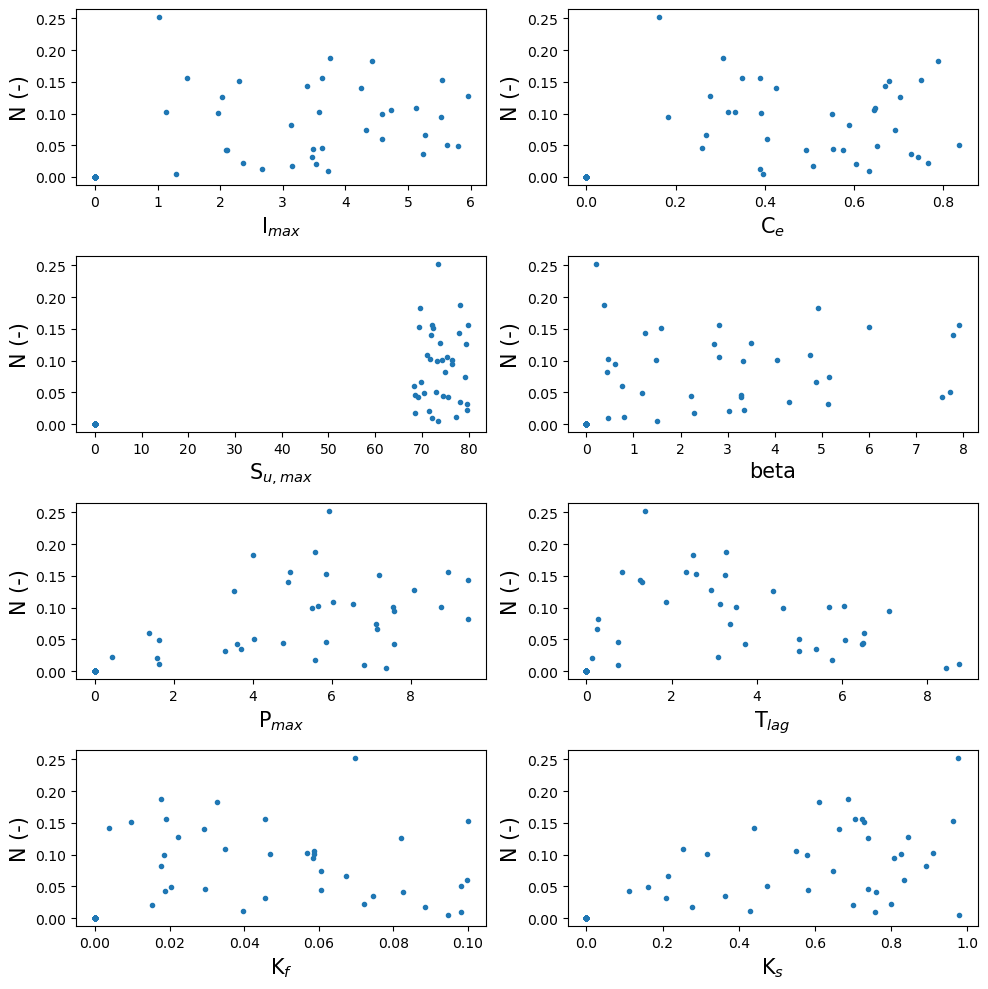

In [158]:
fig, ax = plt.subplots(4,2, figsize=(10,10))


ax[0,0].plot(A[:,0],A[:,8],'.')
ax[0,0].set_xlabel('I$_{max}$', fontsize=15)
ax[0,0].set_ylabel('N (-)', fontsize=15)

#plt.subplot(522)
ax[0,1].plot(A[:,1],A[:,8],'.')
ax[0,1].set_xlabel('C$_{e}$', fontsize=15)
ax[0,1].set_ylabel('N (-)', fontsize=15)

#plt.subplot(523)
ax[1,0].plot(A[:,2],A[:,8],'.')
ax[1,0].set_xlabel('S$_{u,max}$', fontsize=15)
ax[1,0].set_ylabel('N (-)', fontsize=15), 

#plt.subplot(524)
ax[1,1].plot(A[:,3],A[:,8],'.')
ax[1,1].set_xlabel('beta', fontsize=15)
ax[1,1].set_ylabel('N (-)', fontsize=15)

#plt.subplot(525)
ax[2,0].plot(A[:,4],A[:,8],'.')
ax[2,0].set_xlabel('P$_{max}$', fontsize=15)
ax[2,0].set_ylabel('N (-)', fontsize=15)

#plt.subplot(526)
ax[2,1].plot(A[:,5],A[:,8],'.')
ax[2,1].set_xlabel('T$_{lag}$', fontsize=15)
ax[2,1].set_ylabel('N (-)', fontsize=15)

#plt.subplot(527)
ax[3,0].plot(A[:,6],A[:,8],'.')
ax[3,0].set_xlabel('K$_{f}$', fontsize=15)
ax[3,0].set_ylabel('N (-)', fontsize=15)

#plt.subplot(528)
ax[3,1].plot(A[:,7],A[:,8],'.')
ax[3,1].set_xlabel('K$_{s}$', fontsize=15)
ax[3,1].set_ylabel('N (-)', fontsize=15)



plt.tight_layout()
plt.show()



In [84]:
# GLUE
nmax = 100
A = np.zeros((nmax,9))
Sout_lst = np.zeros((nmax, len(Sin)))
n_feasible = 0

for n in range(1,nmax): 
    Rnum = np.random.random(8)  #generate a vector of random number
    
    Par = Rnum * (ParMaxn - ParMinn) + ParMinn # calculate the random parameter set
    df, Obj, Sout = HBVMod(Par, df_data_after_training, Sin, 365+180, snow=True) #call the model

    if Obj>0:
        A[n_feasible,0:8]         = Par
        A[n_feasible,8]           = Obj
        Sout_lst[n_feasible, :]   = Sout
        n_feasible                = n_feasible + 1


np.savetxt(f'{data_folder}\\MC2_after.txt',A[0:n_feasible,:], delimiter =',')


#find the optimum

Opt_obj_after = A.argmax(axis=0)[8]

#find the optimal parameter set
OptPar_after   = A[Opt_obj_after, 0:8]
Sout_Opt_after = Sout_lst[Opt_obj_after, :]





After 2000: Imax: 1.018, Ce: 0.163, Sumax: 73.428, beta: 0.204,Pmax: 5.946,   Tlag: 1.387,   Kf: 0.070,  Ks: 0.975
Before 2000: Imax: 4.374, Ce: 0.535, Sumax: 73.000, beta: 2.045,Pmax: 3.152,   Tlag: 0.418,   Kf: 0.064,  Ks: 0.997


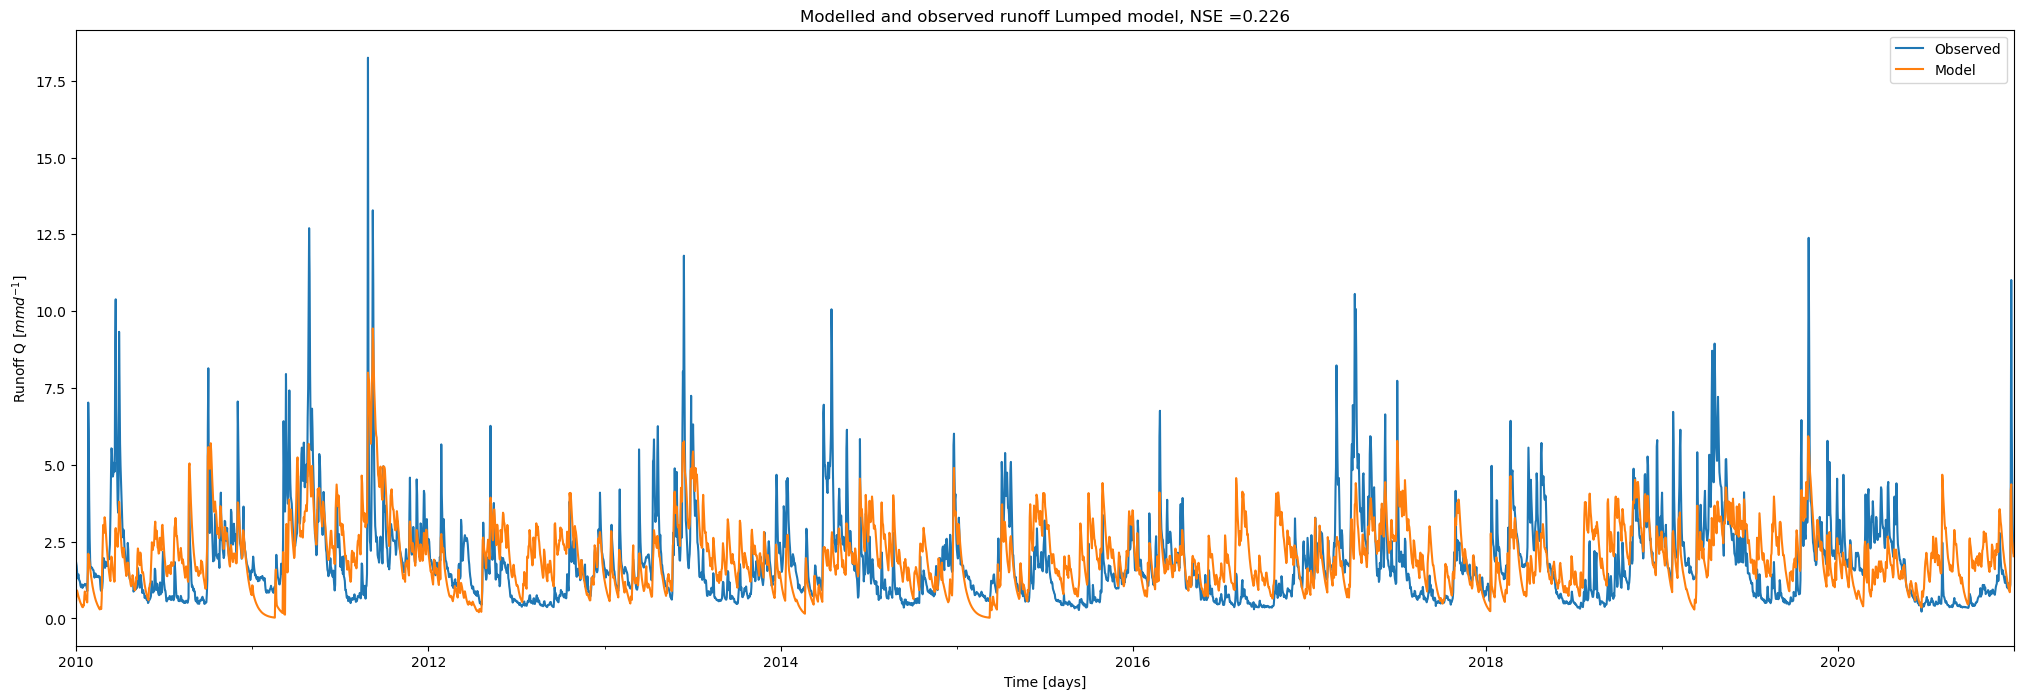

In [87]:
df_after, Obj_after, _ = HBVMod(OptPar_after, df_data_after_test, Sout_Opt_after, 0, snow=True,  mode='Test')

fig, ax = plt.subplots(figsize=(25,8))

df_after.Q.plot(label='Observed', ax=ax)
df_after.Qm.plot(label='Model',  ax=ax)

ax.set_xlabel('Time [days]')
ax.set_ylabel('Runoff Q [$mmd^{-1}$]')
ax.set_title(f'Modelled and observed runoff Lumped model, NSE ={Obj_after:.3f}')
ax.legend()
#ax2.legend()

#align_zeros([ax,ax2])


print(f'After 2000: Imax: {OptPar_after[0]:.3f}, Ce: {OptPar_after[1]:.3f}, Sumax: {OptPar_after[2]:.3f}, beta: {OptPar_after[3]:.3f},'
                f'Pmax: {OptPar_after[4]:.3f},   Tlag: {OptPar_after[5]:.3f},   Kf: {OptPar_after[6]:.3f},  Ks: {OptPar_after[7]:.3f}')
print(f'Before 2000: Imax: {OptPar_before[0]:.3f}, Ce: {OptPar_before[1]:.3f}, Sumax: {OptPar_before[2]:.3f}, beta: {OptPar_before[3]:.3f},'
                f'Pmax: {OptPar_before[4]:.3f},   Tlag: {OptPar_before[5]:.3f},   Kf: {OptPar_before[6]:.3f},  Ks: {OptPar_before[7]:.3f}')

In [ ]:
df_before.Pl_snow.plot()

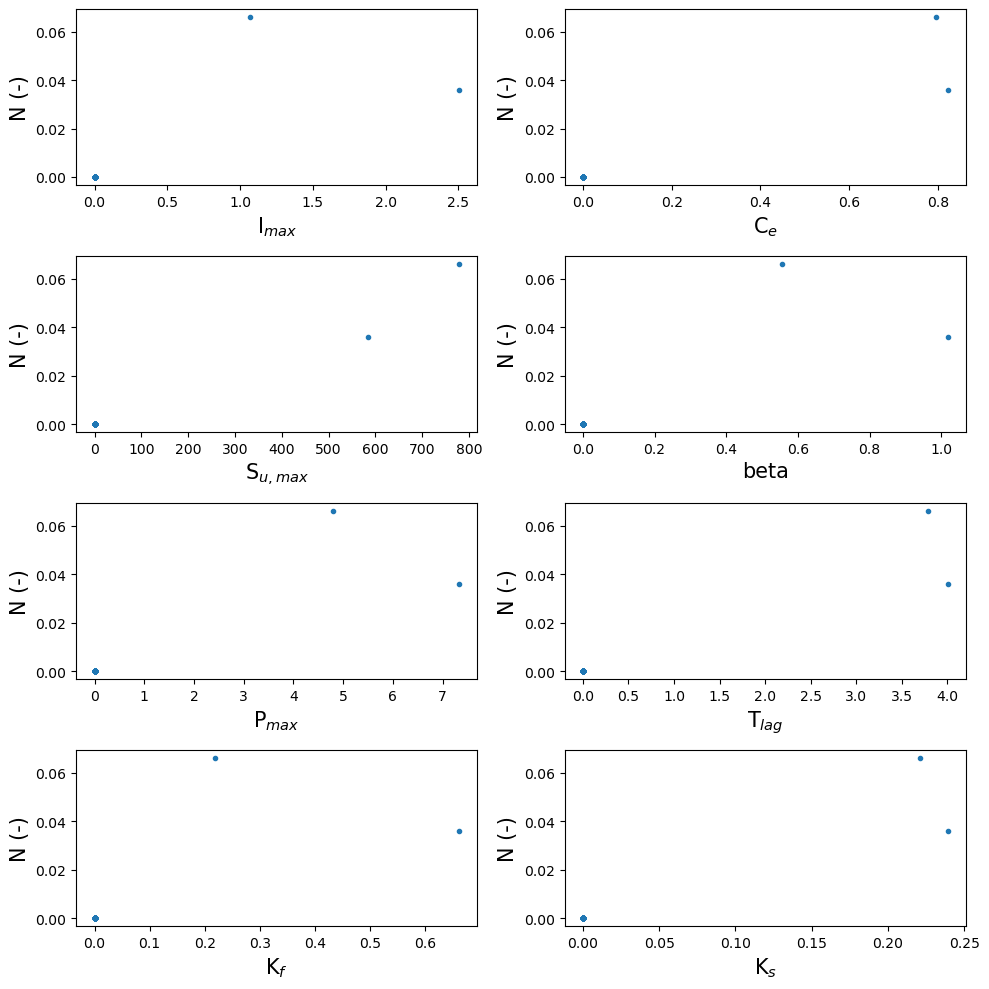

In [27]:
fig, ax = plt.subplots(4,2, figsize=(10,10))


ax[0,0].plot(A[:,0],A[:,8],'.')
ax[0,0].set_xlabel('I$_{max}$', fontsize=15)
ax[0,0].set_ylabel('N (-)', fontsize=15)

#plt.subplot(522)
ax[0,1].plot(A[:,1],A[:,8],'.')
ax[0,1].set_xlabel('C$_{e}$', fontsize=15)
ax[0,1].set_ylabel('N (-)', fontsize=15)

#plt.subplot(523)
ax[1,0].plot(A[:,2],A[:,8],'.')
ax[1,0].set_xlabel('S$_{u,max}$', fontsize=15)
ax[1,0].set_ylabel('N (-)', fontsize=15), 

#plt.subplot(524)
ax[1,1].plot(A[:,3],A[:,8],'.')
ax[1,1].set_xlabel('beta', fontsize=15)
ax[1,1].set_ylabel('N (-)', fontsize=15)

#plt.subplot(525)
ax[2,0].plot(A[:,4],A[:,8],'.')
ax[2,0].set_xlabel('P$_{max}$', fontsize=15)
ax[2,0].set_ylabel('N (-)', fontsize=15)

#plt.subplot(526)
ax[2,1].plot(A[:,5],A[:,8],'.')
ax[2,1].set_xlabel('T$_{lag}$', fontsize=15)
ax[2,1].set_ylabel('N (-)', fontsize=15)

#plt.subplot(527)
ax[3,0].plot(A[:,6],A[:,8],'.')
ax[3,0].set_xlabel('K$_{f}$', fontsize=15)
ax[3,0].set_ylabel('N (-)', fontsize=15)

#plt.subplot(528)
ax[3,1].plot(A[:,7],A[:,8],'.')
ax[3,1].set_xlabel('K$_{s}$', fontsize=15)
ax[3,1].set_ylabel('N (-)', fontsize=15)



plt.tight_layout()
plt.show()



In [20]:
df_data_before

,T,Pev,P,Q,Pe,Qm,PSnow,S_snow,Pl_snow
1980-01-01,-4.244118,0.212411,0.000000,2.769318,0.212411,0.009971,0.000000,11.232353,-11.232353
1980-01-02,-3.066830,0.167835,0.000000,2.639043,0.167835,0.247413,0.000000,11.232353,0.000000
1980-01-03,-6.372549,0.235660,0.023756,2.574587,0.235660,0.570658,0.023756,11.256109,0.000000
1980-01-04,-10.202124,0.167202,0.000000,2.413105,0.167202,0.887251,0.000000,11.256109,0.000000
1980-01-05,-7.726471,0.192151,0.000000,2.250887,0.192151,1.264792,0.000000,11.256109,0.000000
...,...,...,...,...,...,...,...,...,...
2000-12-27,-9.268421,0.289313,0.415153,2.938826,0.289313,0.831902,0.415153,8.690923,0.000000
2000-12-28,-10.826471,0.187339,0.004811,3.040582,0.187339,0.828112,0.004811,8.695733,0.000000
2000-12-29,-12.647059,0.147024,0.000000,3.048002,0.147024,0.821448,0.000000,8.695733,0.000000
2000-12-30,-9.794118,2.019325,5.093873,2.885167,2.019325,0.816950,5.093873,13.789607,0.000000


'1982'